In [1]:
import numpy as np
import random
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
import warnings

In [2]:
def BS_call(S0,K,T,r,sigma): ## calculate BS call price
    T=T/365
    d1 = (np.log(S0/K) + (r+0.5*(sigma)**2)*T)/(sigma*np.sqrt(T))
    d2 = (np.log(S0/K) + (r-0.5*(sigma)**2)*T)/(sigma*np.sqrt(T))
    call_price = S0*norm.cdf(d1) - (K*np.exp(-r*T)*norm.cdf(d2))
    return call_price
def vega_call(S0,K,T,r,sigma):# vega will be used in Newton-Raphson method
    T=T/365
    d1 = (np.log(S0/K) + (r+0.5*(sigma)**2)*T)/(sigma*np.sqrt(T))
    vega = S0*norm.pdf(d1,0,1)*(T)**(0.5)
    return vega

In [12]:
BS_call(1615.70,1620,35,0.045,0.271)

55.378897656501294

In [93]:
def imp_vol(price_data,S0,T,r): ## computes implied volatility
    data = price_data
    ## price_data preprocessing
    if 'ASK PRICE' in data.columns:
        data["ASK PRICE"] = [float(str(i).replace(",", "")) for i in data["ASK PRICE"]]# removing comas from data entries if found to convert them in float
        data["BID PRICE"] = [float(str(i).replace(",", "")) for i in data["BID PRICE"]]
        data["STRIKE PRICE"] = [float(str(i).replace(",", "")) for i in data["STRIKE PRICE"]]
        price = data[['ASK PRICE', 'BID PRICE']].mean(axis=1) ##Market price that will be used
    elif 'Settle Price' in data.columns:
        data = data.rename(columns={'Strike Price':'STRIKE PRICE'})
        price = data['Settle Price']
    else: warnings.warn("No price data found")
    temp = np.linspace(0,1,1000)    
    vol = [] # to store imp vol 
    u=1 #right most point of interval
    l=0 #left most point of interval 
# Finding the interval of convergence for Newton-Raphson method
    for i in range(len(price)):
        K=data['STRIKE PRICE'][i]
        for j in range(1,len(temp)):
            if BS_call(S0,K,T,r,temp[j]) > price[i]:
                l = temp[j-1]
                break
        for k in range(1,len(temp)):    
            if BS_call(S0,K,T,r,temp[-(k+1)]) < price[i]:   
                u = temp[-k]
                break
        g = random.uniform(l,u)## initial point for Newton-Raphson method
        h = (BS_call(S0,K,T,r,g) - price[i])/(vega_call(S0,K,T,r,g))
        while abs(h) > 0.001:
            g = g - h
            h = (BS_call(S0,K,T,r,g) - price[i])/(vega_call(S0,K,T,r,g))  
        vol.append(round(g,4))
    return(np.array(vol))

TATA Motors implied volatility

In [94]:
## TATA_Motors,Dated-28/01/2022,S0=497.30,T=27
tata_data = pd.read_csv('tata.csv')

In [95]:
tata_data

,IV,BID PRICE,ASK PRICE,ASK QTY,STRIKE PRICE
0,61.86,54.95,56.10,"2,850",460
1,58.34,47.60,48.10,"2,850",470
2,56.59,40.50,40.90,"5,700",480
3,53.34,34.20,34.40,"2,850",490
4,52.32,28.60,28.70,"2,850",500
5,51.60,23.75,23.90,"5,700",510
6,50.88,19.40,19.50,"2,850",520
7,50.27,15.65,15.80,"2,850",530
8,50.05,12.65,12.80,"2,850",540
9,49.70,10.10,10.20,"8,550",550


No handles with labels found to put in legend.


0.006256019323641679


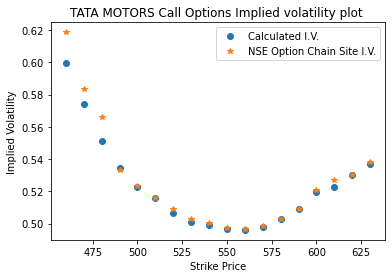

In [96]:
tata_iv = imp_vol(tata_data,S0=497.30,T=27,r=0.1)
MID_PRICE = (tata_data["BID PRICE"] + tata_data["ASK PRICE"])/2
plt.plot(tata_data['STRIKE PRICE'],tata_iv,'o')
iv_list = tata_data['IV'].tolist()
IV = [i*0.01 for i in iv_list]
rmse = np.sqrt(np.sum((np.array(IV) - np.array(tata_iv))**2)/len(IV))
plt.plot(tata_data['STRIKE PRICE'],IV,'*')
plt.legend(loc="upper right") 
plt.legend(["Calculated I.V.","NSE Option Chain Site I.V."])
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.title("TATA MOTORS Call Options Implied volatility plot ")
plt.savefig("TATA_IV_plot.png")
print(rmse)

In [97]:
tata_iv_data = pd.DataFrame({'BID PRICE':tata_data['BID PRICE'],'ASK PRICE':tata_data['ASK PRICE'],'MID PRICE':MID_PRICE,'STRIKE PRICE':tata_data['STRIKE PRICE'],'I.V.(NSE Site)':IV,'I.V.(computed)':tata_iv})
tata_iv_data

,BID PRICE,ASK PRICE,MID PRICE,STRIKE PRICE,I.V.(NSE Site),I.V.(computed)
0,54.95,56.10,55.525,460.0,0.6186,0.5998
1,47.60,48.10,47.850,470.0,0.5834,0.5739
2,40.50,40.90,40.700,480.0,0.5659,0.5509
3,34.20,34.40,34.300,490.0,0.5334,0.5347
4,28.60,28.70,28.650,500.0,0.5232,0.5227
5,23.75,23.90,23.825,510.0,0.5160,0.5158
6,19.40,19.50,19.450,520.0,0.5088,0.5068
7,15.65,15.80,15.725,530.0,0.5027,0.5012
8,12.65,12.80,12.725,540.0,0.5005,0.4989
9,10.10,10.20,10.150,550.0,0.4970,0.4964


In [98]:
import base64
import pandas as pd
from IPython.display import HTML

def create_download_link( df, title = "Download CSV file", filename = "data.csv"):
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

df1 = tata_iv_data 
create_download_link(df1)

NIFTY implied volatility,S0=17053.95,dated 29/11/2021 

In [99]:
data1 =pd.read_csv('nifty_29nov_2dec.csv')
data1=data1[(data1['Strike Price'].between(16800,18200))&(data1['Date'] == '29-Nov-2021' )].reset_index()
data2 =pd.read_csv('nifty_29nov_9dec.csv')
data2=data2[(data2['Strike Price'].between(16800,18200))&(data2['Date'] == '29-Nov-2021' )].reset_index()
data3 =pd.read_csv('nifty_29nov_16dec.csv')
data3=data3[(data3['Strike Price'].between(16800,18200))&(data3['Date'] == '29-Nov-2021' )].reset_index()
data4 =pd.read_csv('nifty_29nov_30dec.csv')
data4=data4[(data4['Strike Price'].between(16800,18200))&(data4['Date'] == '29-Nov-2021' )]
data4 = data4.sort_values(by=['Strike Price'], ascending=True)
data4 = data4.reset_index()


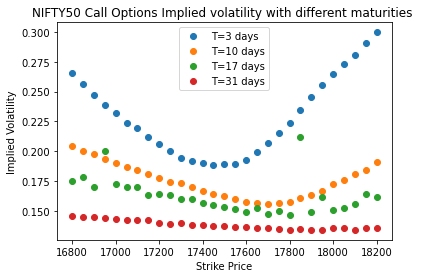

In [100]:
d1=imp_vol(data1,S0=17053.95,T=3,r=0.1)
d2=imp_vol(data2,S0=17053.95,T=10,r=0.1)
d3=imp_vol(data3,S0=17053.95,T=17,r=0.1)
d4=imp_vol(data4,S0=17053.95,T=31,r=0.1)
plt.plot(data1['Strike Price'],d1,'o',label = 'T=3 days')
plt.plot(data2['Strike Price'],d2,'o',label = 'T=10 days')
plt.plot(data3['Strike Price'],d3,'o',label = 'T=17 days')
plt.plot(data4['Strike Price'],d4,'o',label = 'T=31 days')
plt.legend(loc="upper center") 
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.title("NIFTY50 Call Options Implied volatility with different maturities ")
plt.savefig("NIFTY50_IV_plot.png")

<Figure size 936x720 with 0 Axes>

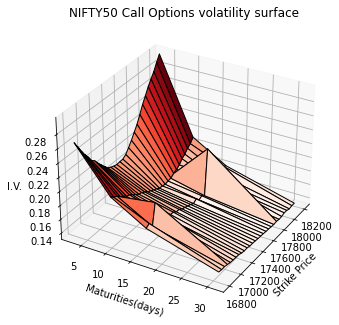

In [101]:
## plotting NIFTY50 volatility surface
x1 =np.zeros((len(data1),4))
for i in range(len(data1)):
    x1[i][0]=d1[i]
for i in range(len(data1)):
    x1[i][1]=d2[i]
for i in range(len(data1)):
    x1[i][2]=d3[i]
for i in range(len(data1)):
    x1[i][3]=d4[i]    
y1 = np.zeros((len(data1),4))
for j in range(4):
    for i in range(len(data1)):
        y1[i][j]=data1['Strike Price'][i]
z1 = np.zeros((len(data1),4))
l=[3,10,17,31]
for j in range(4):
    for i in range(len(data1)):
        z1[i][j]=l[j]   
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(13, 10))
fig = plt.figure()
ax = Axes3D(fig,auto_add_to_figure=False)
ax.plot_surface(y1,z1,x1,cmap='Reds',edgecolor='black')
ax.invert_xaxis()
ax.set_ylabel('Maturities(days)')
ax.set_xlabel('Strike Price')
ax.set_zlabel('I.V.')
fig.add_axes(ax)
#ax.set_zlim(0.20,0.45)
ax.view_init(30,30)
plt.title('NIFTY50 Call Options volatility surface')
plt.show()

In [102]:
nifty_data_iv = pd.DataFrame({'STRIKE PRICE':data1['Strike Price'],'Settle Price(T=3)':data1['Settle Price'],'I.V.(T=3)':d1,'Settle Price(T=10)':data2['Settle Price'],'I.V.(T=10)':d2,'Settle Price(T=17)':data3['Settle Price'],'I.V.(T=17)':d3,'Settle Price(T=31)':data4['Settle Price'],'I.V.(T=31)':d4})
nifty_data_iv

,STRIKE PRICE,Settle Price(T=3),I.V.(T=3),Settle Price(T=10),I.V.(T=10),Settle Price(T=17),I.V.(T=17),Settle Price(T=31),I.V.(T=31)
0,16800,330.45,0.2657,408.70,0.2045,455.45,0.1754,525.70,0.1459
1,16850,289.90,0.2567,371.10,0.2002,425.05,0.1783,490.00,0.1451
2,16900,249.90,0.2472,335.70,0.1981,382.35,0.1702,458.25,0.1453
3,16950,212.95,0.2389,300.35,0.1934,393.90,0.2005,424.85,0.1442
4,17000,179.30,0.2317,268.25,0.1904,324.75,0.1727,390.70,0.1429
5,17050,147.30,0.2233,236.60,0.1866,291.60,0.1700,362.75,0.1425
6,17100,119.70,0.2191,208.35,0.1847,265.60,0.1701,333.20,0.1422
7,17150,94.25,0.2121,180.60,0.1810,231.40,0.1630,304.70,0.1421
8,17200,72.20,0.2061,155.25,0.1776,208.85,0.1640,278.70,0.1402
9,17250,53.85,0.2002,132.45,0.1746,187.15,0.1636,252.85,0.1393


In [103]:
df2 = nifty_data_iv 
create_download_link(df2)